In [1]:
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import logictensornetworks as ltn
import pandas as pd
import seaborn as sns
sns.set(font_scale=1.2)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
df = pd.read_csv("/Users/eduard.hogea/Documents/Facultate/Internship/explorare/KNN99---LTN/datesets/Cantilever/training_sectiune/tot.csv", on_bad_lines='skip', skiprows=1)
df = df.sample(frac=1) #shuffle
print(df.shape)

(36573, 11)


In [3]:
df.drop_duplicates(keep= 'first', inplace=True) #eliminarea dublurilor liniilor
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace = True)
print('Null values in dataset are',len(df[df.isnull().any(1)]))
df.shape

Null values in dataset are 0


(36573, 11)

In [4]:
from sklearn.model_selection import KFold

kf = KFold(n_splits = 2, shuffle = True, random_state = 2)
listakf = list(kf.split(df))

In [5]:
result = listakf[0]
train = df.iloc[result[0]]
test =  df.iloc[result[1]]
results = listakf[1]
train2 = df.iloc[results[0]]
test2 =  df.iloc[results[1]]

In [6]:
train.shape

(18286, 11)

In [7]:
from sklearn.model_selection import train_test_split

X_train = train[['Mod 1', 'Mod 2','Mod 3','Mod 4','Mod 5','Mod 6','Mod 7','Mod 8']].values
y_train = train[['Severitate def', 'Severitate inc.','Pozitie']].values

X_test = test[['Mod 1', 'Mod 2','Mod 3','Mod 4','Mod 5','Mod 6','Mod 7','Mod 8']].values
y_test = test[['Severitate def', 'Severitate inc.','Pozitie']].values

X_train2 = train2[['Mod 1', 'Mod 2','Mod 3','Mod 4','Mod 5','Mod 6','Mod 7','Mod 8']].values
y_train2 = train2[['Severitate def', 'Severitate inc.','Pozitie']].values

X_test2 = test2[['Mod 1', 'Mod 2','Mod 3','Mod 4','Mod 5','Mod 6','Mod 7','Mod 8']].values
y_test2 = test2[['Severitate def', 'Severitate inc.','Pozitie']].values



#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

#x_comp_train, x_comp_test, y_comp_train, y_comp_test = train_test_split(x_comp, y_comp, test_size=.2)

In [8]:
sample_size = X_train.shape[0]
time_steps = X_train.shape[1]
input_dimensions = 1

X_train_reshaped = X_train.reshape(sample_size, time_steps, input_dimensions)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print("After reshape train date set shape:\n", X_train_reshaped.shape)
print("1 Sample shape:\n", X_train_reshaped[0].shape)
print("An example sample:\n", X_train_reshaped[0])

After reshape train date set shape:
 (18286, 8, 1)
1 Sample shape:
 (8, 1)
An example sample:
 [[0.00100733]
 [0.00058672]
 [0.0013928 ]
 [0.00010882]
 [0.00082019]
 [0.00158682]
 [0.00013668]
 [0.00078332]]


In [9]:
sample_size = X_train2.shape[0]
time_steps = X_train2.shape[1]
input_dimensions = 1

X_train_reshaped2 = X_train2.reshape(sample_size, time_steps, input_dimensions)
X_test_reshaped2 = X_test2.reshape(X_test2.shape[0], X_test2.shape[1], 1)
print("After reshape train date set shape:\n", X_train_reshaped2.shape)
print("1 Sample shape:\n", X_train_reshaped2[0].shape)
print("An example sample:\n", X_train_reshaped2[0])

After reshape train date set shape:
 (18287, 8, 1)
1 Sample shape:
 (8, 1)
An example sample:
 [[0.00149308]
 [0.00098166]
 [0.00069891]
 [0.00057509]
 [0.00059287]
 [0.0007071 ]
 [0.0008617 ]
 [0.00100042]]


In [10]:
batch_size= 2000
ds_train = tf.data.Dataset.from_tensor_slices((X_train_reshaped,y_train)).batch(batch_size)
ds_test = tf.data.Dataset.from_tensor_slices((X_test_reshaped,y_test)).batch(batch_size)

ds_train_2 = tf.data.Dataset.from_tensor_slices((X_train_reshaped2,y_train2)).batch(batch_size)
ds_test_2 = tf.data.Dataset.from_tensor_slices((X_test_reshaped2,y_test2)).batch(batch_size)

#ds_comp_train = tf.data.Dataset.from_tensor_slices((x_comp_train,y_comp_train)).batch(batch_size)
#ds_comp_test = tf.data.Dataset.from_tensor_slices((x_comp,y_comp)).batch(batch_size)

Metal device set to: Apple M1


2022-08-26 16:20:05.288693: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-26 16:20:05.288790: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
#df['Freq 1    f1 [Hz]'] = df['Freq 1    f1 [Hz]'].astype(float, errors = 'raise')
df.dtypes

Pozitie            float64
Severitate def     float64
Severitate inc.    float64
Mod 1              float64
Mod 2              float64
Mod 3              float64
Mod 4              float64
Mod 5              float64
Mod 6              float64
Mod 7              float64
Mod 8              float64
dtype: object

In [12]:
import keras
def build_conv1D_model():

    n_timesteps = X_train_reshaped.shape[1] #13
    n_features  = X_train_reshaped.shape[2] #1 
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
    model.add(keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu', name="Conv1D_1"))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv1D_2"))
  
    model.add(keras.layers.Conv1D(filters=16, kernel_size=2, activation='relu', name="Conv1D_3"))
  
    model.add(keras.layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(8, activation='relu', name="Dense_1"))
    model.add(keras.layers.Dense(3, name="Dense_2"))

    return model

# logits_model = build_conv1D_model()
# f = ltn.Predicate(ltn.utils.LogitsToPredicateModel(logits_model,single_label=True))
# logits_model.summary()
model_conv = build_conv1D_model()
model_conv.summary()
f = ltn.Function(model_conv)

Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 5, 64)             320       
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 Conv1D_2 (Conv1D)           (None, 3, 32)             6176      
                                                                 
 Conv1D_3 (Conv1D)           (None, 2, 16)             1040      
                                                                 
 MaxPooling1D (MaxPooling1D)  (None, 1, 16)            0         
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 Dense_1 (Dense)             (None, 8)                

In [13]:
eq = ltn.Predicate.Lambda(
    #lambda args: tf.exp(-0.05*tf.sqrt(tf.reduce_sum(tf.square(args[0]-args[1]),axis=1)))        
    lambda args: 1/(1+0.5*(tf.reduce_sum(abs(args[0]-args[1]),axis=1)))
)

In [14]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=2),semantics="exists")

In [15]:
@tf.function
def axioms(x_data, y_data):
    x = ltn.Variable("x", x_data)
    y = ltn.Variable("y", y_data)
    return Forall(ltn.diag(x,y), eq([f(x),y])).tensor

In [16]:
for x, y in ds_test:
    print("Initial sat level %.5f"%axioms(x,y))
    break

2022-08-26 16:20:06.058128: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-26 16:20:06.058183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Initial sat level 0.78278


In [17]:
metrics_dict = {
    'train_sat': tf.keras.metrics.Mean(name='train_sat'),
    'test_sat': tf.keras.metrics.Mean(name='test_sat'),
    'train_accuracy': tf.keras.metrics.RootMeanSquaredError(name="train_accuracy"),
    'test_accuracy': tf.keras.metrics.RootMeanSquaredError(name="test_accuracy")
}

In [18]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
@tf.function
def train_step(x, y):
    # sat and update
    with tf.GradientTape() as tape:
        sat = axioms(x, y)
        loss = 1.-sat
    gradients = tape.gradient(loss, f.trainable_variables)
    optimizer.apply_gradients(zip(gradients, f.trainable_variables))
    sat = axioms(x, y)
    metrics_dict['train_sat'](sat)
    # accuracy
    metrics_dict['train_accuracy'](y,f.model(x))
    
@tf.function
def test_step(x, y):
    # sat
    sat = axioms(x, y)
    metrics_dict['test_sat'](sat)
    # accuracy
    metrics_dict['test_accuracy'](y,f.model(x))

In [19]:
from collections import defaultdict

def train(
        epochs,
        metrics_dict, 
        ds_train, 
        ds_test, 
        train_step, 
        test_step,
        track_metrics=1,
        csv_path=None,
        scheduled_parameters=defaultdict(lambda : {})
    ):
    """
    Args:
        epochs: int, number of training epochs.
        metrics_dict: dict, {"metrics_label": tf.keras.metrics instance}.
        ds_train: iterable dataset, e.g. using tf.data.Dataset.
        ds_test: iterable dataset, e.g. using tf.data.Dataset.
        train_step: callable function. the arguments passed to the function
            are the itered elements of ds_train.
        test_step: callable function. the arguments passed to the function
            are the itered elements of ds_test.
        csv_path: (optional) path to create a csv file, to save the metrics.
        scheduled_parameters: (optional) a dictionary that returns kwargs for
            the train_step and test_step functions, for each epoch.
            Call using scheduled_parameters[epoch].
    """
    template = "Epoch {}"
    for metrics_label in metrics_dict.keys():
        template += ", %s: {:.4f}" % metrics_label
    if csv_path is not None:
        csv_file = open(csv_path,"w+")
        headers = ",".join(["Epoch"]+list(metrics_dict.keys()))
        csv_template = ",".join(["{}" for _ in range(len(metrics_dict)+1)])
        csv_file.write(headers+"\n")
    
    for epoch in range(epochs):
        for metrics in metrics_dict.values():
            metrics.reset_states()

        for batch_elements in ds_train:
            train_step(*batch_elements,**scheduled_parameters[epoch])
        for batch_elements in ds_test:
            test_step(*batch_elements,**scheduled_parameters[epoch])

        metrics_results = [metrics.result() for metrics in metrics_dict.values()]
        if epoch%track_metrics == 0:
            print(template.format(epoch,*metrics_results))
        if csv_path is not None:
            csv_file.write(csv_template.format(epoch,*metrics_results)+"\n")
            csv_file.flush()
    if csv_path is not None:
        csv_file.close()

In [20]:
EPOCHS = 5000

modelul = train(
    EPOCHS,
    metrics_dict,
    ds_train,
    ds_test,
    train_step,
    test_step,
    csv_path="regression_results_kfold2_1_mh.csv",
    track_metrics=200
)

2022-08-26 16:20:06.688356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-26 16:20:07.821784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-26 16:20:08.149259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-26 16:20:08.310475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 0, train_sat: 0.7901, test_sat: 0.7972, train_accuracy: 0.3214, test_accuracy: 0.3086
Epoch 200, train_sat: 0.9313, test_sat: 0.9290, train_accuracy: 0.0882, test_accuracy: 0.0922
Epoch 400, train_sat: 0.9514, test_sat: 0.9476, train_accuracy: 0.0595, test_accuracy: 0.0657
Epoch 600, train_sat: 0.9620, test_sat: 0.9597, train_accuracy: 0.0452, test_accuracy: 0.0489
Epoch 800, train_sat: 0.9679, test_sat: 0.9650, train_accuracy: 0.0370, test_accuracy: 0.0415
Epoch 1000, train_sat: 0.9727, test_sat: 0.9750, train_accuracy: 0.0315, test_accuracy: 0.0287
Epoch 1200, train_sat: 0.9763, test_sat: 0.9709, train_accuracy: 0.0267, test_accuracy: 0.0347
Epoch 1400, train_sat: 0.9790, test_sat: 0.9805, train_accuracy: 0.0246, test_accuracy: 0.0222
Epoch 1600, train_sat: 0.9812, test_sat: 0.9790, train_accuracy: 0.0213, test_accuracy: 0.0249
Epoch 1800, train_sat: 0.9818, test_sat: 0.9823, train_accuracy: 0.0218, test_accuracy: 0.0207
Epoch 2000, train_sat: 0.9835, test_sat: 0.9802, train_ac

/Users/eduard.hogea/miniforge3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/eduard.hogea/miniforge3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


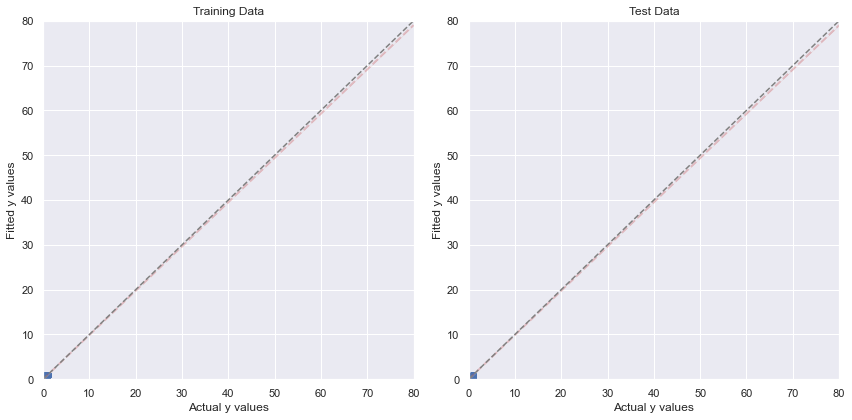

In [21]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
ax = axs[0]
data = {'y_pred':[],'y_true':[]}
for x,y in ds_train:
    data['y_pred'].extend(f.model(x)[:,2].numpy())
    data['y_true'].extend(y[:,2].numpy())
df = pd.DataFrame(data,columns=['y_pred','y_true'])
ax.set_xlim(0,80)
ax.set_ylim(0,80)
sns.regplot("y_true","y_pred",data=df,ax=ax,truncate=False,
            scatter_kws={'alpha':0.5},line_kws={'color':'r','alpha':0.3,'linestyle':'--','linewidth':2})
ax.plot([0,100],[0,100],color="gray",linestyle="--")
ax.set_xlabel("Actual y values")
ax.set_ylabel("Fitted y values")
ax.set_title("Training Data")

ax = axs[1]
data = {'y_pred':[],'y_true':[]}
for x,y in ds_test:
    data['y_pred'].extend(f.model(x)[:,2].numpy())
    data['y_true'].extend(y[:,2].numpy())
df = pd.DataFrame(data,columns=['y_pred','y_true'])
ax.set_ylim(0,80)
ax.set_xlim(0,80)
sns.regplot("y_true","y_pred",data=df,ax=ax,truncate=False,
            scatter_kws={'alpha':0.5},line_kws={'color':'r','alpha':0.3,'linestyle':'--','linewidth':2})
ax.plot([0,100],[0,100],color="gray",linestyle="--")
ax.set_xlabel("Actual y values")
ax.set_ylabel("Fitted y values")
ax.set_title("Test Data")
plt.tight_layout()
plt.savefig("LTN_regresie_kfold2_1_mh.pdf")

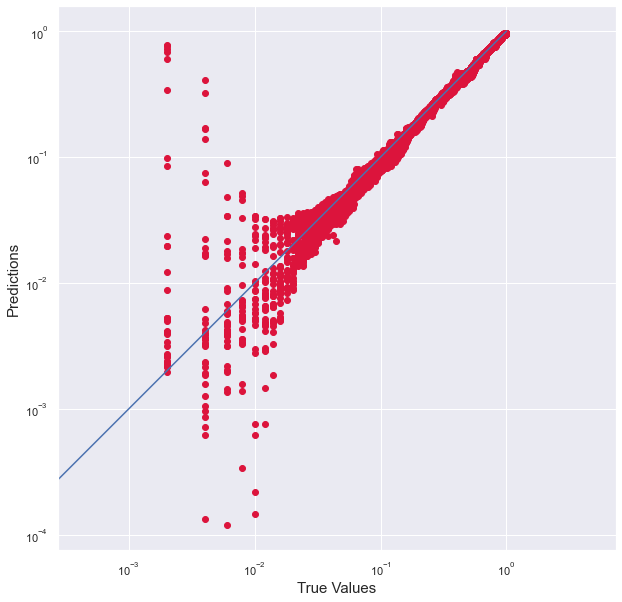

In [22]:
plt.figure(figsize=(10,10))
plt.scatter(df['y_true'], df['y_pred'], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(df['y_pred']), max(df['y_true']))
p2 = min(min(df['y_pred']), min(df['y_true']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.savefig("LTN_regresie_2_mh.png")
plt.show()

In [23]:
df = pd.read_csv("/Users/eduard.hogea/Documents/Facultate/Internship/explorare/KNN99---LTN/datesets/Cantilever/date_test_corectate.csv", on_bad_lines='skip')
df = df.sample(frac=1) #shuffle
x = df[['Mod 1', 'Mod 2','Mod 3','Mod 4','Mod 5','Mod 6','Mod 7','Mod 8']]
y = df[['Severitate def', 'Severitate inc.','Pozitie']]
batch_size= 32
ds_test = tf.data.Dataset.from_tensor_slices((x,y)).batch(batch_size)

data = {'y_pred':[],'y_true':[],'def':[],'inc':[],'Mod 1':[],'Mod 2':[],'Mod 3':[],'Mod 4':[],'Mod 5':[],'Mod 6':[],'Mod 7':[],'Mod 8':[]}
for x,y in ds_test:
    data['y_pred'].extend(f.model(x)[:,2].numpy())
    data['y_true'].extend(y[:,2].numpy())
    data['def'].extend(y[:,0].numpy())
    data['inc'].extend(y[:,1].numpy())
    data['Mod 1'].extend(x[:,0].numpy())
    data['Mod 2'].extend(x[:,1].numpy())
    data['Mod 3'].extend(x[:,2].numpy())
    data['Mod 4'].extend(x[:,3].numpy())
    data['Mod 5'].extend(x[:,4].numpy())
    data['Mod 6'].extend(x[:,5].numpy())
    data['Mod 7'].extend(x[:,6].numpy())
    data['Mod 8'].extend(x[:,7].numpy())
#'Severitate def', 'Severitate inc.'

In [24]:
data_plot = pd.DataFrame(data,columns=['y_pred','y_true','def','inc','Mod 1', 'Mod 2','Mod 3','Mod 4','Mod 5','Mod 6','Mod 7','Mod 8'])
dif =data_plot["y_true"] - data_plot["y_pred"]

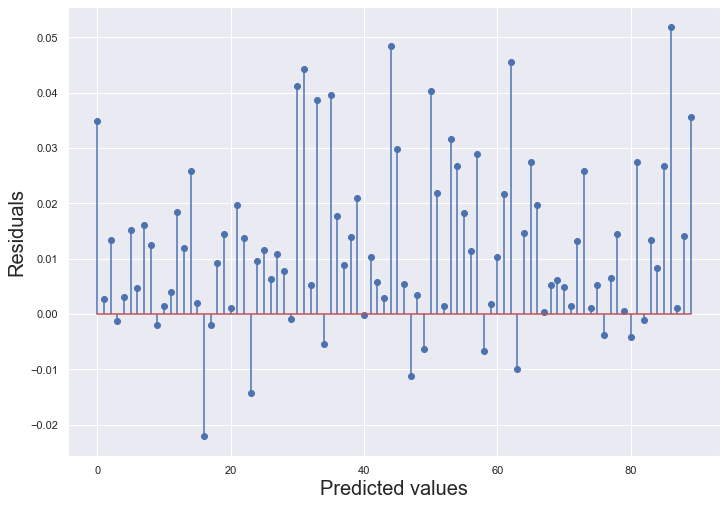

In [25]:
plt.stem(dif)
plt.xlabel("Predicted values", size = "20")
plt.ylabel("Residuals", size = "20")
plt.savefig("residuals_kfold2_1_mh.png")

In [26]:
from openpyxl import Workbook
!pip install openpyxl
data_plot.to_excel("output_kfold2_1_mh.xlsx")

# Fold 2

In [27]:
import keras
def build_conv1D_model():

    n_timesteps = X_train_reshaped.shape[1] #13
    n_features  = X_train_reshaped.shape[2] #1 
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
    model.add(keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu', name="Conv1D_1"))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv1D_2"))
  
    model.add(keras.layers.Conv1D(filters=16, kernel_size=2, activation='relu', name="Conv1D_3"))
  
    model.add(keras.layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(8, activation='relu', name="Dense_1"))
    model.add(keras.layers.Dense(3, name="Dense_2"))

    return model

# logits_model = build_conv1D_model()
# f = ltn.Predicate(ltn.utils.LogitsToPredicateModel(logits_model,single_label=True))
# logits_model.summary()
model_conv = build_conv1D_model()
model_conv.summary()
f = ltn.Function(model_conv)

Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 5, 64)             320       
                                                                 
 dropout_1 (Dropout)         (None, 5, 64)             0         
                                                                 
 Conv1D_2 (Conv1D)           (None, 3, 32)             6176      
                                                                 
 Conv1D_3 (Conv1D)           (None, 2, 16)             1040      
                                                                 
 MaxPooling1D (MaxPooling1D)  (None, 1, 16)            0         
                                                                 
 flatten_1 (Flatten)         (None, 16)                0         
                                                                 
 Dense_1 (Dense)             (None, 8)                

In [28]:
eq = ltn.Predicate.Lambda(
    #lambda args: tf.exp(-0.05*tf.sqrt(tf.reduce_sum(tf.square(args[0]-args[1]),axis=1)))        
    lambda args: 1/(1+0.5*(tf.reduce_sum(abs(args[0]-args[1]),axis=1)))
)

In [29]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=2),semantics="exists")

In [30]:
@tf.function
def axioms(x_data, y_data):
    x = ltn.Variable("x", x_data)
    y = ltn.Variable("y", y_data)
    return Forall(ltn.diag(x,y), eq([f(x),y])).tensor

In [31]:
for x, y in ds_test_2:
    print("Initial sat level %.5f"%axioms(x,y))
    break

Initial sat level 0.78292


2022-08-26 16:36:32.349850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [32]:
metrics_dict = {
    'train_sat': tf.keras.metrics.Mean(name='train_sat'),
    'test_sat': tf.keras.metrics.Mean(name='test_sat'),
    'train_accuracy': tf.keras.metrics.RootMeanSquaredError(name="train_accuracy"),
    'test_accuracy': tf.keras.metrics.RootMeanSquaredError(name="test_accuracy")
}

In [33]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
@tf.function
def train_step(x, y):
    # sat and update
    with tf.GradientTape() as tape:
        sat = axioms(x, y)
        loss = 1.-sat
    gradients = tape.gradient(loss, f.trainable_variables)
    optimizer.apply_gradients(zip(gradients, f.trainable_variables))
    sat = axioms(x, y)
    metrics_dict['train_sat'](sat)
    # accuracy
    metrics_dict['train_accuracy'](y,f.model(x))
    
@tf.function
def test_step(x, y):
    # sat
    sat = axioms(x, y)
    metrics_dict['test_sat'](sat)
    # accuracy
    metrics_dict['test_accuracy'](y,f.model(x))

In [34]:
from collections import defaultdict

def train(
        epochs,
        metrics_dict, 
        ds_train_2, 
        ds_test_2, 
        train_step, 
        test_step,
        track_metrics=1,
        csv_path=None,
        scheduled_parameters=defaultdict(lambda : {})
    ):
    """
    Args:
        epochs: int, number of training epochs.
        metrics_dict: dict, {"metrics_label": tf.keras.metrics instance}.
        ds_train: iterable dataset, e.g. using tf.data.Dataset.
        ds_test: iterable dataset, e.g. using tf.data.Dataset.
        train_step: callable function. the arguments passed to the function
            are the itered elements of ds_train.
        test_step: callable function. the arguments passed to the function
            are the itered elements of ds_test.
        csv_path: (optional) path to create a csv file, to save the metrics.
        scheduled_parameters: (optional) a dictionary that returns kwargs for
            the train_step and test_step functions, for each epoch.
            Call using scheduled_parameters[epoch].
    """
    template = "Epoch {}"
    for metrics_label in metrics_dict.keys():
        template += ", %s: {:.4f}" % metrics_label
    if csv_path is not None:
        csv_file = open(csv_path,"w+")
        headers = ",".join(["Epoch"]+list(metrics_dict.keys()))
        csv_template = ",".join(["{}" for _ in range(len(metrics_dict)+1)])
        csv_file.write(headers+"\n")
    
    for epoch in range(epochs):
        for metrics in metrics_dict.values():
            metrics.reset_states()

        for batch_elements in ds_train_2:
            train_step(*batch_elements,**scheduled_parameters[epoch])
        for batch_elements in ds_test_2:
            test_step(*batch_elements,**scheduled_parameters[epoch])

        metrics_results = [metrics.result() for metrics in metrics_dict.values()]
        if epoch%track_metrics == 0:
            print(template.format(epoch,*metrics_results))
        if csv_path is not None:
            csv_file.write(csv_template.format(epoch,*metrics_results)+"\n")
            csv_file.flush()
    if csv_path is not None:
        csv_file.close()

In [35]:
EPOCHS = 5000

modelul2 = train(
    EPOCHS,
    metrics_dict,
    ds_train_2,
    ds_test_2,
    train_step,
    test_step,
    csv_path="regression_results_kfold2_2_mh.csv",
    track_metrics=200
)

2022-08-26 16:36:32.776788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-26 16:36:33.317458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-26 16:36:33.680578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-26 16:36:33.848895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 0, train_sat: 0.7906, test_sat: 0.7958, train_accuracy: 0.3206, test_accuracy: 0.3103
Epoch 200, train_sat: 0.9309, test_sat: 0.9318, train_accuracy: 0.0891, test_accuracy: 0.0869
Epoch 400, train_sat: 0.9545, test_sat: 0.9539, train_accuracy: 0.0553, test_accuracy: 0.0558
Epoch 600, train_sat: 0.9681, test_sat: 0.9671, train_accuracy: 0.0373, test_accuracy: 0.0401
Epoch 800, train_sat: 0.9743, test_sat: 0.9749, train_accuracy: 0.0300, test_accuracy: 0.0284
Epoch 1000, train_sat: 0.9790, test_sat: 0.9763, train_accuracy: 0.0236, test_accuracy: 0.0281
Epoch 1200, train_sat: 0.9811, test_sat: 0.9786, train_accuracy: 0.0216, test_accuracy: 0.0262
Epoch 1400, train_sat: 0.9835, test_sat: 0.9843, train_accuracy: 0.0192, test_accuracy: 0.0188
Epoch 1600, train_sat: 0.9848, test_sat: 0.9859, train_accuracy: 0.0179, test_accuracy: 0.0170
Epoch 1800, train_sat: 0.9867, test_sat: 0.9845, train_accuracy: 0.0147, test_accuracy: 0.0183
Epoch 2000, train_sat: 0.9873, test_sat: 0.9850, train_ac

/Users/eduard.hogea/miniforge3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/eduard.hogea/miniforge3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


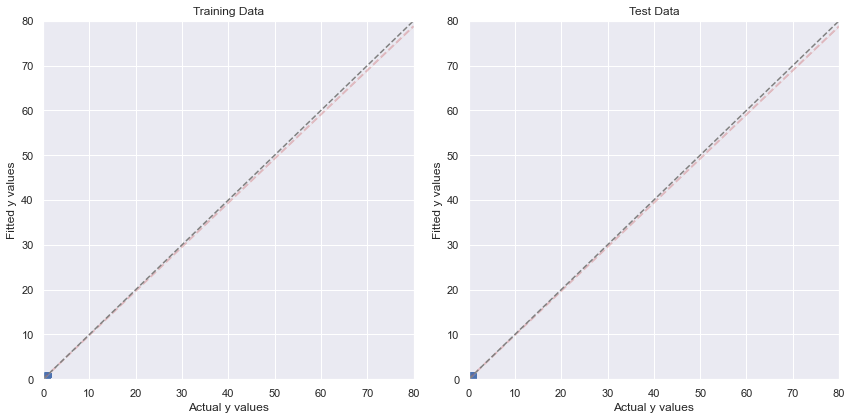

In [36]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
ax = axs[0]
data = {'y_pred':[],'y_true':[]}
for x,y in ds_train_2:
    data['y_pred'].extend(f.model(x)[:,2].numpy())
    data['y_true'].extend(y[:,2].numpy())
df = pd.DataFrame(data,columns=['y_pred','y_true'])
ax.set_xlim(0,80)
ax.set_ylim(0,80)
sns.regplot("y_true","y_pred",data=df,ax=ax,truncate=False,
            scatter_kws={'alpha':0.5},line_kws={'color':'r','alpha':0.3,'linestyle':'--','linewidth':2})
ax.plot([0,100],[0,100],color="gray",linestyle="--")
ax.set_xlabel("Actual y values")
ax.set_ylabel("Fitted y values")
ax.set_title("Training Data")

ax = axs[1]
data = {'y_pred':[],'y_true':[]}
for x,y in ds_test_2:
    data['y_pred'].extend(f.model(x)[:,2].numpy())
    data['y_true'].extend(y[:,2].numpy())
df = pd.DataFrame(data,columns=['y_pred','y_true'])
ax.set_ylim(0,80)
ax.set_xlim(0,80)
sns.regplot("y_true","y_pred",data=df,ax=ax,truncate=False,
            scatter_kws={'alpha':0.5},line_kws={'color':'r','alpha':0.3,'linestyle':'--','linewidth':2})
ax.plot([0,100],[0,100],color="gray",linestyle="--")
ax.set_xlabel("Actual y values")
ax.set_ylabel("Fitted y values")
ax.set_title("Test Data")
plt.tight_layout()
plt.savefig("LTN_regresie_kfold2_2_mh.pdf")

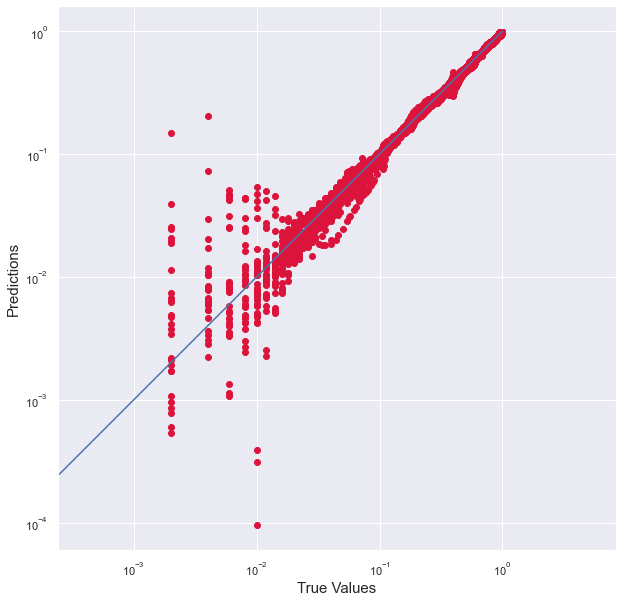

In [37]:
plt.figure(figsize=(10,10))
plt.scatter(df['y_true'], df['y_pred'], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(df['y_pred']), max(df['y_true']))
p2 = min(min(df['y_pred']), min(df['y_true']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.savefig("LTN_regresie_kfold2_3_mh.png")
plt.show()

In [38]:
df = pd.read_csv("/Users/eduard.hogea/Documents/Facultate/Internship/explorare/KNN99---LTN/datesets/Cantilever/date_test_corectate.csv", on_bad_lines='skip')
df = df.sample(frac=1) #shuffle
x = df[['Mod 1', 'Mod 2','Mod 3','Mod 4','Mod 5','Mod 6','Mod 7','Mod 8']]
y = df[['Severitate def', 'Severitate inc.','Pozitie']]
batch_size= 32
ds_test = tf.data.Dataset.from_tensor_slices((x,y)).batch(batch_size)

data = {'y_pred':[],'y_true':[],'def':[],'inc':[],'Mod 1':[],'Mod 2':[],'Mod 3':[],'Mod 4':[],'Mod 5':[],'Mod 6':[],'Mod 7':[],'Mod 8':[]}
for x,y in ds_test:
    data['y_pred'].extend(f.model(x)[:,2].numpy())
    data['y_true'].extend(y[:,2].numpy())
    data['def'].extend(y[:,0].numpy())
    data['inc'].extend(y[:,1].numpy())
    data['Mod 1'].extend(x[:,0].numpy())
    data['Mod 2'].extend(x[:,1].numpy())
    data['Mod 3'].extend(x[:,2].numpy())
    data['Mod 4'].extend(x[:,3].numpy())
    data['Mod 5'].extend(x[:,4].numpy())
    data['Mod 6'].extend(x[:,5].numpy())
    data['Mod 7'].extend(x[:,6].numpy())
    data['Mod 8'].extend(x[:,7].numpy())
#'Severitate def', 'Severitate inc.'

In [39]:
data_plot = pd.DataFrame(data,columns=['y_pred','y_true','def','inc','Mod 1', 'Mod 2','Mod 3','Mod 4','Mod 5','Mod 6','Mod 7','Mod 8'])

In [40]:
dif =data_plot["y_true"] - data_plot["y_pred"]

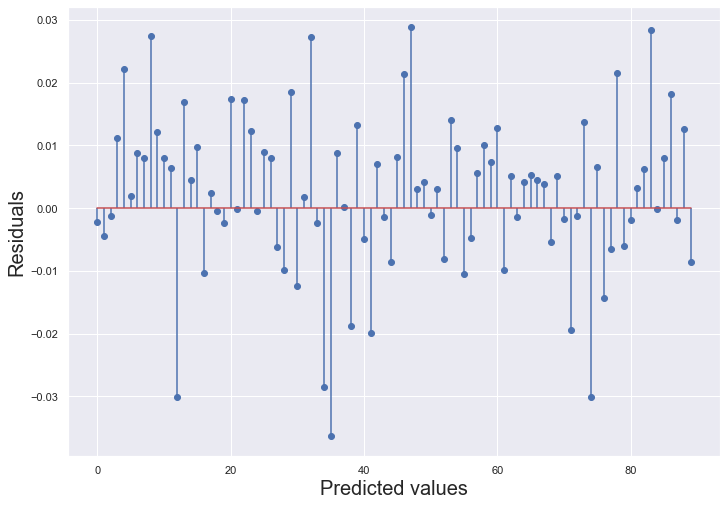

In [41]:
plt.stem(dif)
plt.xlabel("Predicted values", size = "20")
plt.ylabel("Residuals", size = "20")
plt.savefig("residuals_kfold2_2_mh.png")

In [42]:
from openpyxl import Workbook
!pip install openpyxl
data_plot.to_excel("output_kfold2_2_mh.xlsx")